In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy
from sklearn.decomposition import PCA

# Concrete compressive strength

#### dataset - https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength

In [2]:
df_cc = pd.read_csv('./concrete+compressive+strength/Concrete_Data.csv')
df_cc

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [3]:
df_cc.isnull().sum()

Cement (component 1)(kg in a m^3 mixture)                0
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    0
Fly Ash (component 3)(kg in a m^3 mixture)               0
Water  (component 4)(kg in a m^3 mixture)                0
Superplasticizer (component 5)(kg in a m^3 mixture)      0
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     0
Fine Aggregate (component 7)(kg in a m^3 mixture)        0
Age (day)                                                0
Concrete compressive strength(MPa, megapascals)          0
dtype: int64

In [4]:
X = df_cc.drop(columns=['Concrete compressive strength(MPa, megapascals) '])
y = df_cc['Concrete compressive strength(MPa, megapascals) ']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

### Check for correlation and outlier spread

<AxesSubplot:>

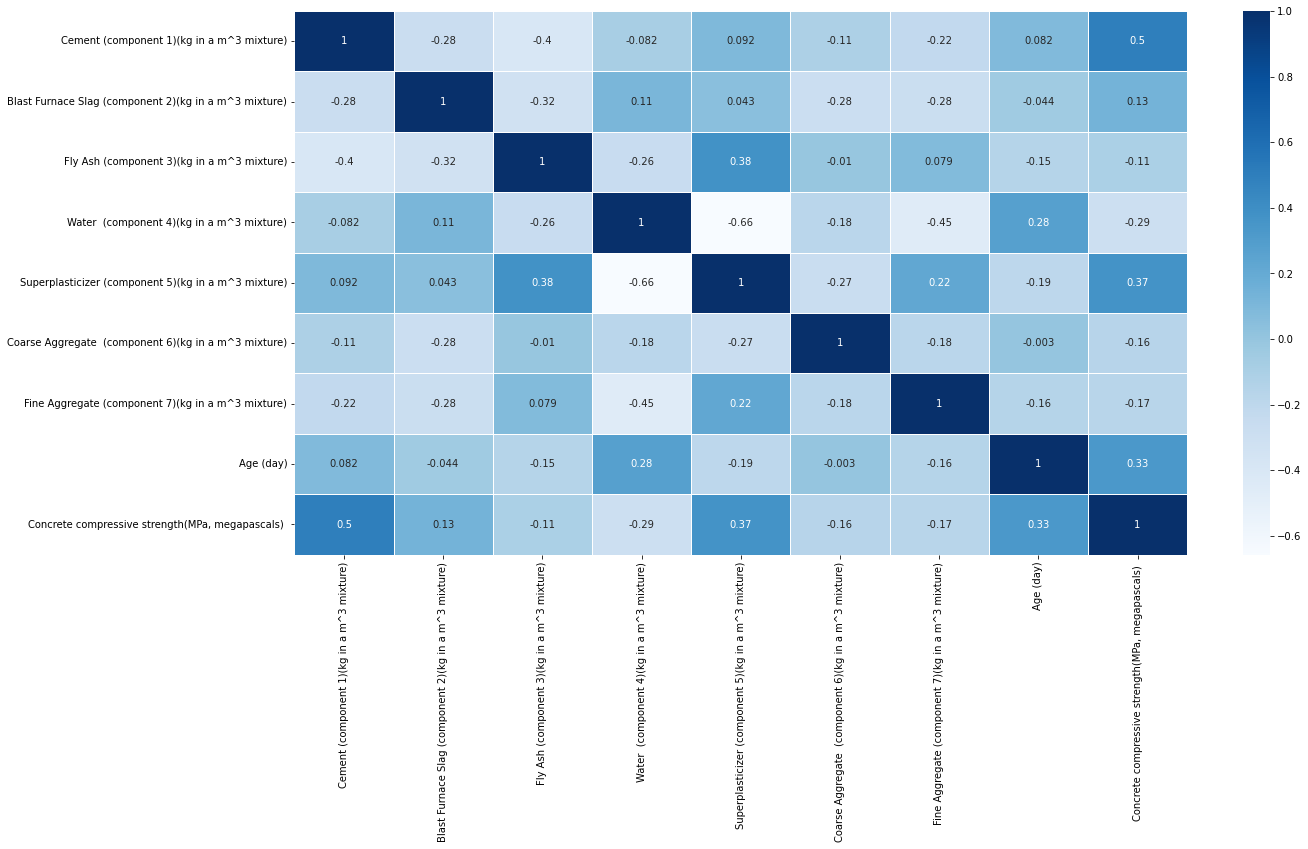

In [5]:
corr_matrix = df_cc.corr()
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", linewidth=0.5)

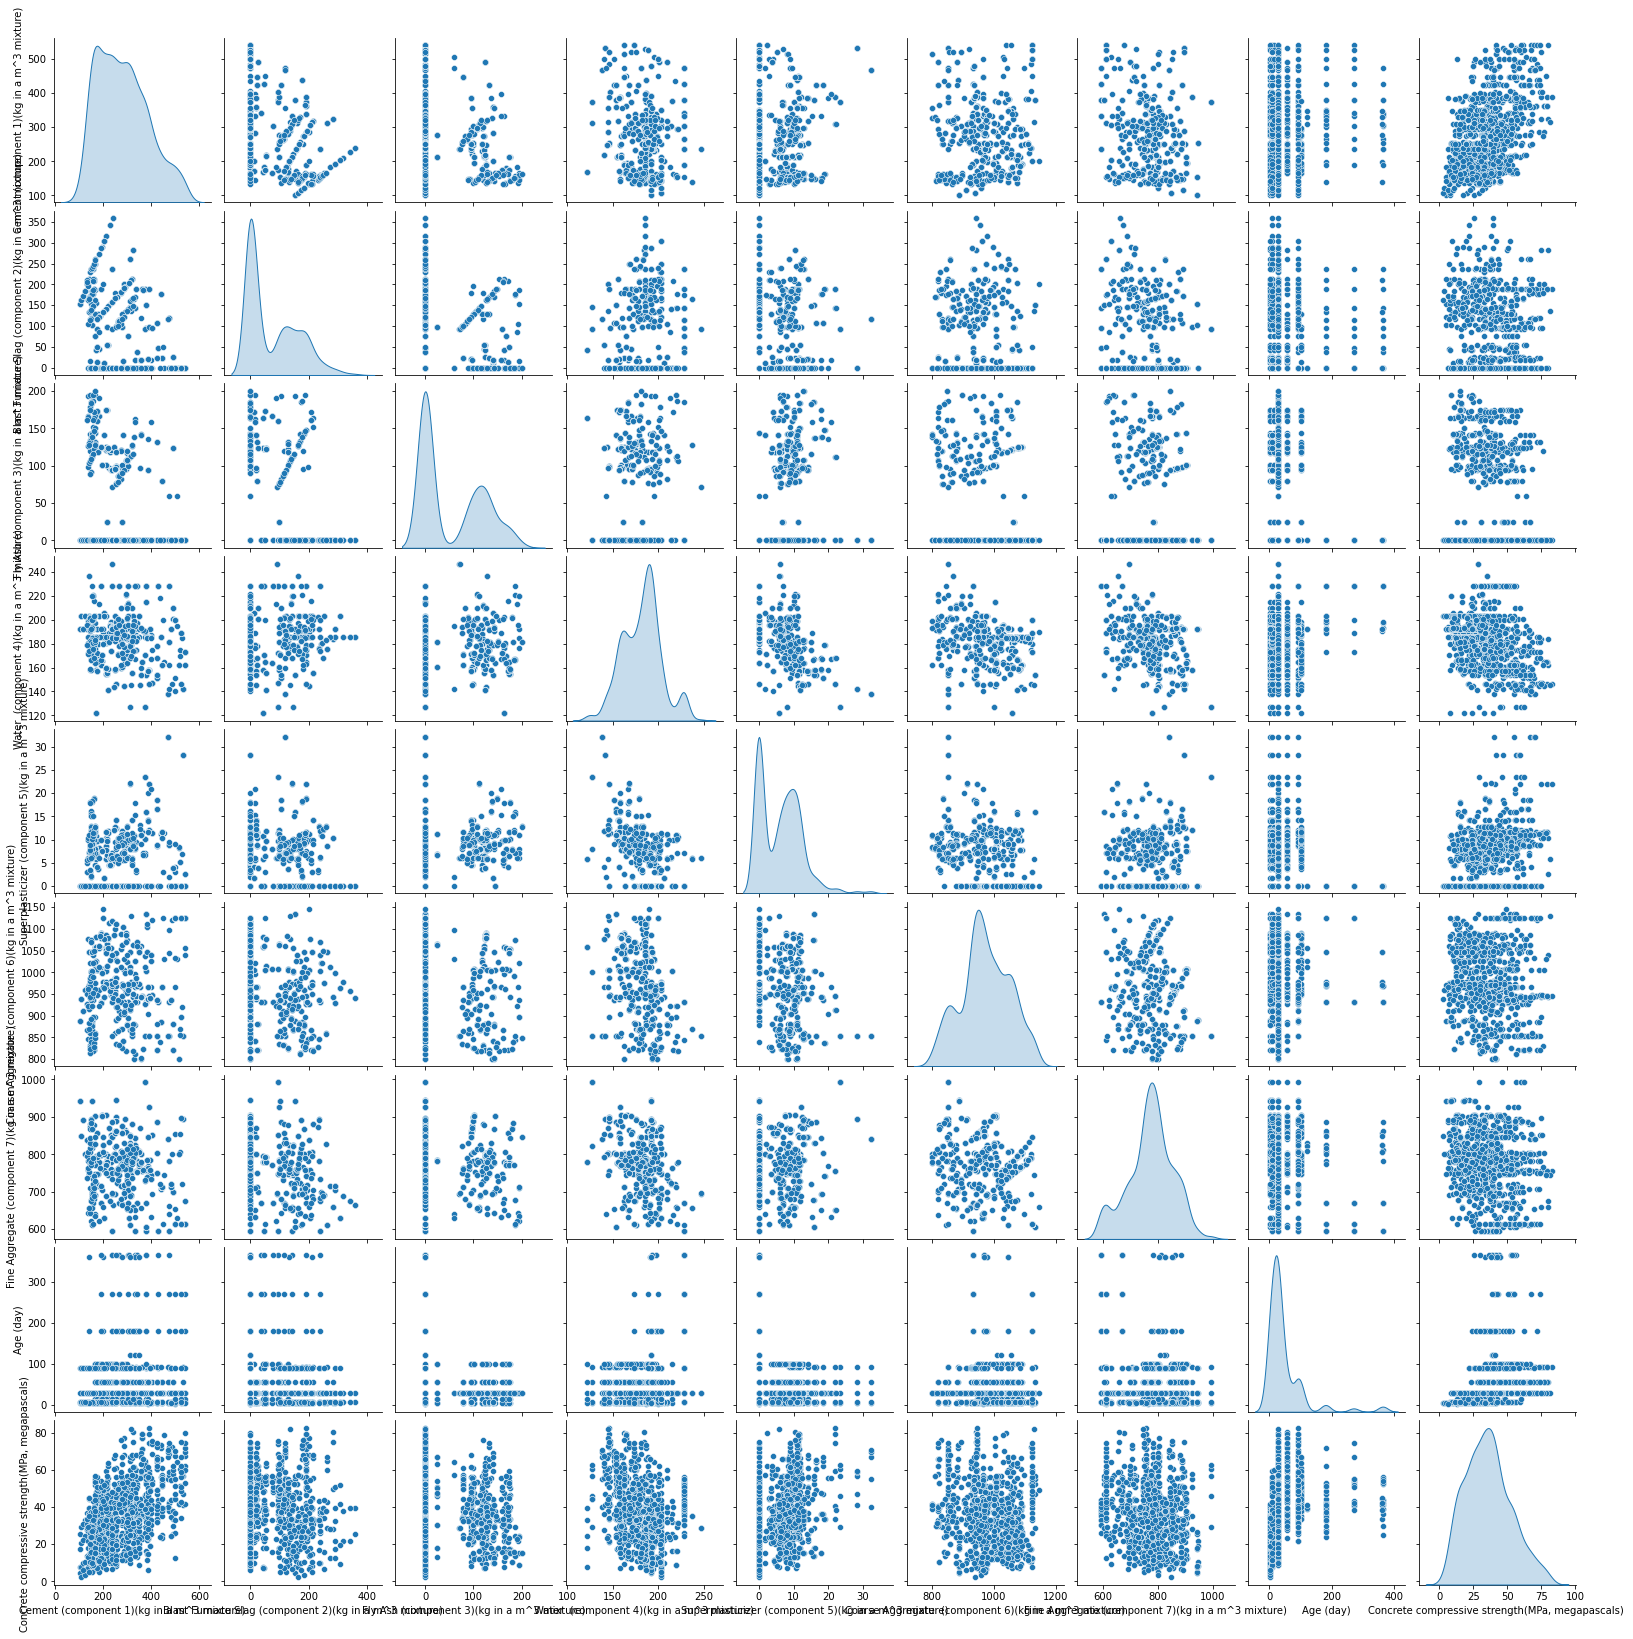

In [6]:
sns.pairplot(df_cc, diag_kind='kde')

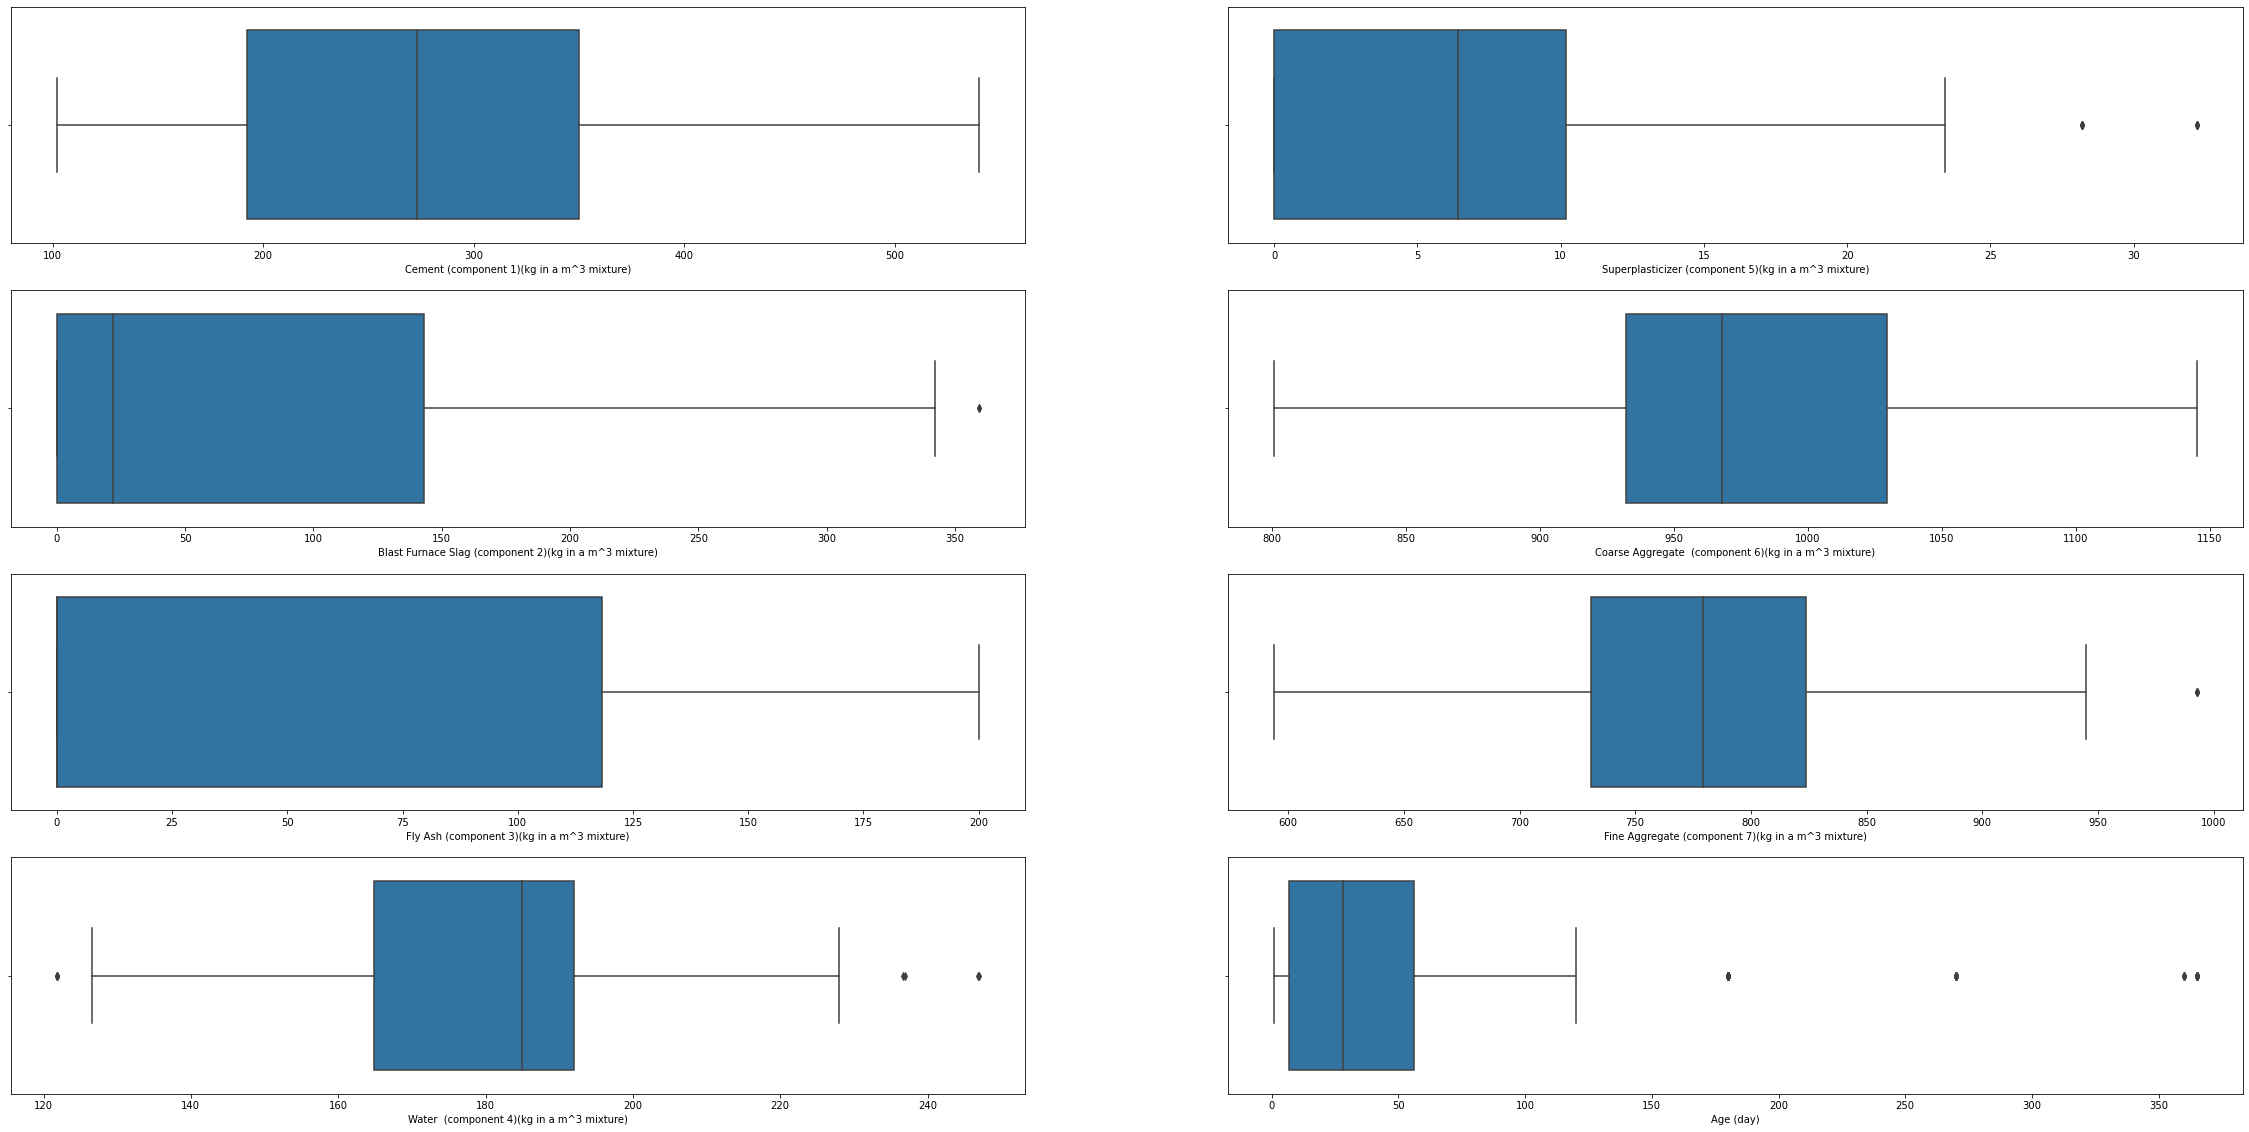

In [7]:
x_vals = list(df_cc.columns)
fig,axes = plt.subplots(4,2,figsize=(40,20))
i,j=0,0
for x in x_vals[:len(x_vals)-1]:
    if i <= 3:
        ax = sns.boxplot(x=df_cc[x], ax=axes[i,0])
        i+=1
    else:
        ax = sns.boxplot(x=df_cc[x], ax=axes[j,1])
        j+=1

### There is no significant correlation between features. Outliers present in AGE are necessary to represent the data thus can not be dropped.

## Decision Tree Regressor

###  Recursive feature elimination 

In [8]:
%%time
est = DecisionTreeRegressor()
cv= RepeatedKFold(n_splits=10, n_repeats=20)

rfecv = RFECV(est, scoring='r2',cv=cv, n_jobs=15)
rfetrain = rfecv.fit(X_train, y_train)
print('Optimal number of features :', rfecv.n_features_)

# rfe = RFE(estimator=est, n_features_to_select=rfecv.n_features_, step=1)
# rfe = rfe.fit(X_train, y_train)

rfe_X_train = X_train.loc[:, rfecv.get_support()]
rfe_X_test = X_test.loc[:, rfecv.get_support()]

Optimal number of features : 8
Wall time: 1.77 s


### Hyperparameter tuning 

In [9]:
%%time
param = {
    "criterion" : ['squared_error', 'friedman_mse'],
    "splitter" : ['best','random'],
    "max_depth" : [5, 10, 15, 20, 25, 30, None],
    "max_features" : ["auto","log2","sqrt",None]
}

cv = RepeatedKFold(n_splits=10, n_repeats=20)

est = DecisionTreeRegressor()
grid = GridSearchCV(est, param, n_jobs=15, cv=cv, verbose=3)
grid.fit(rfe_X_train, y_train)

print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

Fitting 200 folds for each of 112 candidates, totalling 22400 fits
0.8383336624100853
DecisionTreeRegressor(criterion='friedman_mse', max_depth=20)
{'criterion': 'friedman_mse', 'max_depth': 20, 'max_features': None, 'splitter': 'best'}
Wall time: 9.92 s


### Find best CCP_ALPHA

In [10]:
%%time
est = DecisionTreeRegressor(criterion='friedman_mse', max_depth=20)
ccp_alphas = est.cost_complexity_pruning_path(rfe_X_train, y_train)['ccp_alphas']

regrs = []
for alpha in ccp_alphas:
    regr = DecisionTreeRegressor(criterion='friedman_mse', max_depth=20,ccp_alpha = alpha)
    regr.fit(rfe_X_train, y_train)
    regrs.append(regr)

# Remove last element as it is a trivial tree with only one node
regrs = regrs[:-1]
ccp_alphas = ccp_alphas[:-1]

train_acc = [cross_val_score(regr,rfe_X_train,y_train,cv=cv).mean() for regr in regrs]
test_acc_r2 = [regr.score(rfe_X_test,y_test) for regr in regrs]

Wall time: 11min 23s


### Plot train and test scores vs alpha values

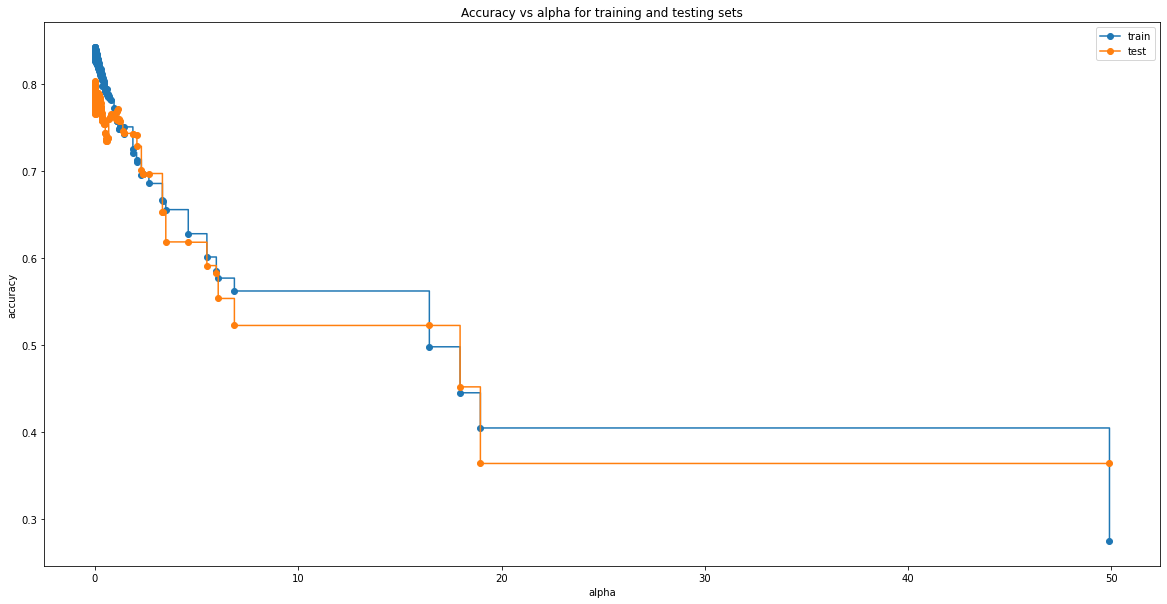

In [11]:
fig,ax = plt.subplots(figsize=(20,10))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_acc, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_acc_r2, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

### Model scores

In [12]:
best_test_acc = max(test_acc_r2)
best_train_acc = train_acc[test_acc_r2.index(best_test_acc)]
best_alpha = ccp_alphas[test_acc_r2.index(best_test_acc)]
best_regr = regrs[test_acc_r2.index(best_test_acc)]
depth = best_regr.get_depth()
y_pred = best_regr.predict(rfe_X_test)
mse = metrics.mean_squared_error(y_pred, y_test)

print("Training accuracy (R2) : ",best_train_acc)
print("Test accuracy (R2) : ",best_test_acc)
print("Root Mean Squared error: ", mse**0.5)
print("Best ccp alpha value: ",best_alpha)
print("Depth of the tree",depth)

Training accuracy (R2) :  0.8320225276589187
Test accuracy (R2) :  0.8028642763699613
Root Mean Squared error:  7.2056600289637345
Best ccp alpha value:  0.0025778519417478316
Depth of the tree 16


### Tree visualization

In [13]:
# plot_tree(best_regr)

## Random Forest Regressor

### Randomized search for approx best hyperparameter

In [14]:
%%time
max_depth = [int(x) for x in np.arange(5,50,step=5)]
max_depth.append(None)
param = {
    'n_estimators' : [int(x) for x in np.arange(50,1000,step=50)],
    'max_features' : ['sqrt', 'log2', None],
    'max_depth' : max_depth,
    'min_samples_split' : [2,3,4,5,6,7,8,9,10],
    'min_samples_leaf': [1,2,3,4,5],
    'bootstrap' : [True, False]
}

est = RandomForestRegressor(n_jobs=15)
cv = RepeatedKFold(n_splits=10, n_repeats=20)

randsearch = RandomizedSearchCV(est, param, n_iter=1000, n_jobs=15, cv=5, verbose=3)
randsearch.fit(X_train, y_train)

print(randsearch.best_score_)
print(randsearch.best_estimator_)
print(randsearch.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
0.9058143114255047
RandomForestRegressor(bootstrap=False, max_depth=30, max_features='log2',
                      min_samples_split=3, n_estimators=900, n_jobs=15)
{'n_estimators': 900, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}
Wall time: 6min 53s


### Recursive Feature elimination

In [15]:
%%time
est = RandomForestRegressor(bootstrap=False, max_depth=30, max_features='log2', min_samples_split=3, n_estimators=900, n_jobs=15)
cv= RepeatedKFold(n_splits=10, n_repeats=20)

rfecv = RFECV(est, scoring='r2',cv=cv, n_jobs=15)
rfetrain = rfecv.fit(X_train, y_train)
print('Optimal number of features :', rfecv.n_features_)

# est = RandomForestRegressor(bootstrap=False, max_depth=30, max_features='log2',n_estimators=650,n_jobs=15)
# rfe = RFE(estimator=est, n_features_to_select=rfecv.n_features_, step=1)
# rfe = rfe.fit(X_train, y_train)

rfe_X_train = X_train.loc[:, rfecv.get_support()]
rfe_X_test = X_test.loc[:, rfecv.get_support()]

Optimal number of features : 8
Wall time: 3min 59s


### Hyperparameter tuning with exhaustive grid search

In [16]:
%%time
param = {
    'n_estimators' : [700,750,800,850,900,950],
    'max_features' : ['sqrt', 'log2', None],
    'max_depth' : [20,25,30,35],
    'min_samples_split' : [2,3,4],
    'min_samples_leaf': [1,2,3],
    'bootstrap' : [False]
}

cv = RepeatedKFold(n_splits=10, n_repeats=20)

est = RandomForestRegressor(n_jobs=15)
grid = GridSearchCV(est, param, n_jobs=15, cv=5, verbose=3)
grid.fit(rfe_X_train, y_train)

print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
0.9082239458114657
RandomForestRegressor(bootstrap=False, max_depth=30, max_features='log2',
                      n_estimators=850, n_jobs=15)
{'bootstrap': False, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 850}
Wall time: 8min 8s


### Model Scores

In [17]:
rf = RandomForestRegressor(bootstrap=False, max_depth=30, max_features='log2', n_estimators=850, n_jobs=15)
rf.fit(rfe_X_train, y_train)

y_pred = rf.predict(rfe_X_test)
mse = metrics.mean_squared_error(y_pred, y_test)
cv = RepeatedKFold(n_splits=10, n_repeats=20)

print("Training score R2: ", cross_val_score(rf, rfe_X_train, y_train, cv=cv, n_jobs=15).mean())
print("Test score R2: ", rf.score(rfe_X_test, y_test))
print("Root Mean Squared Error: ", mse**0.5)

Training score R2:  0.9153144556627499
Test score R2:  0.9261924124496834
Root Mean Squared Error:  4.409015313822515


# Mercedez Benz greener manufacturing dataset

In [18]:
df_mb = pd.read_csv('./mercedez dataset/train.csv')
df_mb

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8405,107.39,ak,s,as,c,d,aa,d,q,...,1,0,0,0,0,0,0,0,0,0
4205,8406,108.77,j,o,t,d,d,aa,h,h,...,0,1,0,0,0,0,0,0,0,0
4206,8412,109.22,ak,v,r,a,d,aa,g,e,...,0,0,1,0,0,0,0,0,0,0
4207,8415,87.48,al,r,e,f,d,aa,l,u,...,0,0,0,0,0,0,0,0,0,0


### Check for null values

In [19]:
df_mb.isnull().sum()

ID      0
y       0
X0      0
X1      0
X2      0
       ..
X380    0
X382    0
X383    0
X384    0
X385    0
Length: 378, dtype: int64

### Convert categorical columns to numerical by one hot encoding

In [20]:
cols = ['X0','X1','X2','X3','X4','X5','X6','X8']
enc = preprocessing.OneHotEncoder(sparse=False)
cat_data = df_mb[cols]
cat_data_enc = enc.fit_transform(cat_data)

df_mb[list(enc.get_feature_names_out())] = pd.DataFrame(cat_data_enc, columns = enc.get_feature_names_out())
df_mb.drop(columns=cols, inplace=True)
df_mb.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,130.81,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,88.53,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,76.26,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,9,80.62,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13,78.02,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Convert data frame to sparse matrix and train-test split

In [21]:
X = df_mb.drop(columns=['ID','y'])
y = df_mb['y']
X_sparse = scipy.sparse.csr_matrix(X.values)

X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2)

### Randomized search for approx best hyperparameter

In [24]:
%%time
max_depth = [int(x) for x in np.arange(5,70,step=5)]
max_depth.append(None)
param = {
    'n_estimators' : [int(x) for x in np.arange(50,1000,step=50)],
    'max_features' : ['sqrt', 'log2', None],
    'max_depth' : max_depth,
    'min_samples_split' : [2,5,7,10],
    'min_samples_leaf': [1,3,5],
    'bootstrap' : [True, False]
}

est = RandomForestRegressor(n_jobs=15)
cv = RepeatedKFold(n_splits=10, n_repeats=20)

randsearch = RandomizedSearchCV(est, param, n_iter=100, n_jobs=15, cv=5, verbose=3)
randsearch.fit(X_train, y_train)

print(randsearch.best_score_)
print(randsearch.best_estimator_)
print(randsearch.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
0.5652389225358593
RandomForestRegressor(max_depth=5, max_features=None, n_estimators=900,
                      n_jobs=15)
{'n_estimators': 900, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 5, 'bootstrap': True}
Wall time: 19min 32s


### Recursive Feature Elimination

In [25]:
%%time
est = RandomForestRegressor(max_depth=5, max_features=None, n_estimators=900, n_jobs=15)
cv= RepeatedKFold(n_splits=10, n_repeats=20)

rfecv = RFECV(est, scoring='r2',cv=5, n_jobs=15)
rfetrain = rfecv.fit(X_train, y_train)
print('Optimal number of features :', rfecv.n_features_)

# est = RandomForestRegressor(max_depth=5, max_features=None, n_estimators=900, n_jobs=15)
# rfe = RFE(estimator=est, n_features_to_select=rfecv.n_features_, step=1)
# rfe = rfe.fit(X_train, y_train)

# rfe_X_train = X_train.loc[:, rfe.get_support()]
# rfe_X_test = X_test.loc[:, rfe.get_support()]

Optimal number of features : 254


AttributeError: loc not found

### Convert sparse matrix to dense, so we can filter out unnecessary features

In [35]:
X_train_dense = pd.DataFrame.sparse.from_spmatrix(X_train, columns=X.columns)
X_test_dense = pd.DataFrame.sparse.from_spmatrix(X_test, columns=X.columns)

rfe_X_train = X_train_dense.loc[:, rfecv.get_support()]
rfe_X_test = X_test_dense.loc[:, rfecv.get_support()]

rfe_X_train = scipy.sparse.csr_matrix(rfe_X_train.values)
rfe_X_test = scipy.sparse.csr_matrix(rfe_X_test.values)

### Hyperparameter Tuning using exhaustive grid search

In [36]:
%%time
param = {
    'n_estimators' : [800,850,900,950,1000],
    'max_features' : ['sqrt', 'log2', None],
    'max_depth' : [5,10,15,20,None],
}

cv = RepeatedKFold(n_splits=10, n_repeats=20)

est = RandomForestRegressor(n_jobs=15)
grid = GridSearchCV(est, param, n_jobs=15, cv=5, verbose=3)
grid.fit(rfe_X_train, y_train)

print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
0.5654469554438426
RandomForestRegressor(max_depth=5, max_features=None, n_estimators=950,
                      n_jobs=15)
{'max_depth': 5, 'max_features': None, 'n_estimators': 950}
Wall time: 19min 37s


### Model scores

In [37]:
rf = RandomForestRegressor(max_depth=5, max_features=None, n_estimators=950, n_jobs=15)
rf.fit(rfe_X_train, y_train)

y_pred = rf.predict(rfe_X_test)
mse = metrics.mean_squared_error(y_pred, y_test)

cv = RepeatedKFold(n_splits=10, n_repeats=20)

print("Training score R2: ", cross_val_score(rf, rfe_X_train, y_train, cv=cv, n_jobs=15).mean())
print("Test score R2: ", rf.score(rfe_X_test, y_test))
print("Root Mean Squared Error: ", mse**0.5)

Training score R2:  0.5732548115216612
Test score R2:  0.5603460908632274
Root Mean Squared Error:  8.468595162900717
